## Bond Distortion Method applied to CdTe vacancies

### Table of contents
* [Generate defects with doped](#generate_defects)
* [Apply rattle+BDM to defects](#apply_BDM)
* [Plot energy of final structures obtained with BDM](#plot_BDM_energy)
* [Analyse defect distortions](#analyse_defect_distortions)

In [1]:
import sys
import os
import BDM

from BDM.BDM import apply_RBDM_defect_dict # module where Bond Distortion and Rattle functions are

In [2]:
import doped
import pymatgen
import ase
from importlib.metadata import version
# check versions
print("Doped version:" , version('doped') )
print("Pymatgen version:" , version('pymatgen') )
print("Ase version:" , version('ase') )

Doped version: 0.0.5
Pymatgen version: 2022.0.9
Ase version: 3.20.1


<a id='generate_defects'></a>

#### 1. Generate defects with doped

In [3]:
from doped.pycdt.core.defectsmaker import ChargedDefectsStructures
from pymatgen.core.structure import Structure

# Specify perfect (bulk) supercell structure
bulk_supercell = Structure.from_file("./CdTe_bulk_supercell_POSCAR")  

# Let's generate the vacancies
def_structs = ChargedDefectsStructures(
    bulk_supercell,
    cellmax=bulk_supercell.num_sites,
    antisites_flag=False,
    include_interstitials=False,
)

Setting up defects...

Number of jobs created:
    bulk = 1
    vacancies:
        vac_1_Cd = 5 with site multiplicity 32
        vac_2_Te = 5 with site multiplicity 32
    substitutions:
Total (non dielectric) jobs created = 11



In [4]:
defect_dictionary = {'vacancies': def_structs.defects['vacancies']}

##### Rationale for BDM   
Deep defect relaxations tend to follow the change in electron count, so for the neutral Cd vacancy, any localised distortions are likely to involve two neighbouring Te moving closer/further apart (as we're going from a -2 oxidation state to 0). For the singly-charged vacancy, likely to have just one neighbouring Te moving, etc.

So, the Bond Distortion Method involves distorting the initial bond lengths around the vacancy for a set of trial distortion amounts, performing a rough `vasp_gam` relaxation for each and then comparing the energies, to see if we find any lower energy structures.

<a id='apply_BDM'></a>

#### 2. Apply the Bond Distortion Method to your defects

In [5]:
# In order to determine the number of the defect nearest neighbours to distort you can set 
# the chemical valences and oxidation states of the atoms in your material:
# Note: (Update in BDM: now the number of extra/missing e- is determined based on the oxidation states)
valences_oxi_states_CdTe = {"valences":   {"Cd": 2, "Te": 6},
                            "oxi_states": {"Cd": +2, "Te": -2}           
                            }

In [6]:
# And input them, along the defect dictionary and INCAR settings to the function:
apply_RBDM_defect_dict?

Signature:
apply_RBDM_defect_dict(
    defects_dict: dict,
    valences_oxi_states: dict,
    incar_settings: dict = {'ADDGRID': False, 'ALGO': 'Normal', 'EDIFFG': -0.01, 'IBRION': 2, 'ISPIN': 2, 'POTIM': 0.2, 'LVHAR': False, 'LSUBROT': False, 'LREAL': 'Auto', 'LWAVE': False},
    dict_number_electrons_user: dict = None,
    bdm_increment: float = 0.1,
    bdm_distortions: list = None,
    std_dev: float = 0.25,
    distorted_elements: dict = None,
    bdm_type: str = 'BDM',
    potcar_settings: dict = None,
    write_files: bool = True,
    verbose: bool = False,
)
Docstring:
Applies rattle+BDM to all defects in your input defect dictionary (in doped format).
It creates the input files for the vasp_gam relaxations of all RBDM distortions.
It also creates a dictionary with an entry for every defect, which in turn links to a dictionary with 
all BDM distortions (and undistorted) for each charge state of the defect (in case wanna check something).
Args:
    defects_dict (dict):
        D


##### Some comments about the default values in the previous function:
* The deafult `INCAR` settings have been tested, and performed better than others (wider interval of BDM distortions lead to defect ground-state).

* The Bond Distortion Increment (`bdm_increment`) determines the increment used to generate the grid for distorting the defect nearest neighbours. Recommended values: 0.1-0.3

* The user can also input a list of distortions using `bdm_distortions` (e.g. [-0.4, 0.4])   

* If the defect is surrounded by chemically different neighbours, the user *can* select the element to distort with `distorted_elements`. This is a dictionary mapping defect name (without charge state) to element symbol (e.g. {'vac_1_Cd': 'Te'} ). If not specified, the nearest neighbours will be selected.   

* The standard deviation (`std_dev`) of the rattle function controls the magnitude of the random distortion applied to your structure. For materials with bond distances ~2.5-3.5 A, `std_dev`=2.5 A performed the best. However, for some systems (highly packed structures/smaller bond lengths) it may be too much. In these cases, it may be better to use `std_dev`=0.15 or 0.05 A.

* Further information on the distorted atoms and their initial and final distances can be obtained by setting the optional keyword `verbose` to True.

Using these distorted structures, we can run `vasp_gam` defect relaxations with these `INCAR` settings:   
`IBRION = 2`, `POTIM = 0.2`, `LREAL = Auto`, `ROPT = 1e-3 1e-3`, `ADDGRID = False`    
to quickly test if these distortions result in a lower energy structure.   
Note: For `ROPT`, set as many `1e-3` as species in your `POTCAR` (see [VASP ROPT](https://www.vasp.at/wiki/index.php/ROPT) )

In [1]:
# Incar settings we'd use
incar_settings = {'ADDGRID': False, 'ALGO': 'Normal', 'EDIFFG': -0.01, 'IBRION': 2, 'ISPIN': 2, 'POTIM': 0.2, 
 'LVHAR': False, 'LSUBROT': False, 'LREAL': 'Auto', 'ROPT': '1e-3 1e-3', 'LWAVE': False, 'LCHARG': False}

In [8]:
defect_dictionary

{'vacancies': [{'name': 'vac_1_Cd',
   'unique_site': PeriodicSite: Cd (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000],
   'bulk_supercell_site': PeriodicSite: Cd (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000],
   'defect_type': 'vacancy',
   'site_specie': 'Cd',
   'site_multiplicity': 32,
   'supercell': {'size': [1, 1, 1],
    'structure': Structure Summary
    Lattice
        abc : 13.086768 13.086768 13.086768
     angles : 90.0 90.0 90.0
     volume : 2241.2856479961474
          A : 13.086768 0.0 0.0
          B : 0.0 13.086768 0.0
          C : 0.0 0.0 13.086768
    PeriodicSite: Cd (0.0000, 0.0000, 6.5434) [0.0000, 0.0000, 0.5000]
    PeriodicSite: Cd (0.0000, 6.5434, 0.0000) [0.0000, 0.5000, 0.0000]
    PeriodicSite: Cd (0.0000, 6.5434, 6.5434) [0.0000, 0.5000, 0.5000]
    PeriodicSite: Cd (6.5434, 0.0000, 0.0000) [0.5000, 0.0000, 0.0000]
    PeriodicSite: Cd (6.5434, 0.0000, 6.5434) [0.5000, 0.0000, 0.5000]
    PeriodicSite: Cd (6.5434, 6.5434, 0.0000) [0.5000, 0.5000, 

In [9]:
bdm_defect_dict = apply_RBDM_defect_dict(
                        defect_dictionary, 
                        valences_oxi_states = valences_oxi_states_CdTe, 
                        incar_settings = incar_settings, 
                        bdm_increment = 0.1,
                        )

vac_1_Cd_-2
vac_1_Cd_-1
vac_1_Cd_0
vac_1_Cd_1
vac_1_Cd_2
vac_2_Te_-2
vac_2_Te_-1
vac_2_Te_0
vac_2_Te_1
vac_2_Te_2
Applying BDM... Will rattle with std dev of 0.25 A 


Defect: vac_1_Cd
Number of missing electrons in neutral state: 2

Defect vac_1_Cd in charge state: -2. Number of distorted neighbours: 0

Defect vac_1_Cd in charge state: -1. Number of distorted neighbours: 1

Defect vac_1_Cd in charge state: 0. Number of distorted neighbours: 2

Defect vac_1_Cd in charge state: 1. Number of distorted neighbours: 3

Defect vac_1_Cd in charge state: 2. Number of distorted neighbours: 4


Defect: vac_2_Te
Number of extra electrons in neutral state: -2

Defect vac_2_Te in charge state: -2. Number of distorted neighbours: 4

Defect vac_2_Te in charge state: -1. Number of distorted neighbours: 3

Defect vac_2_Te in charge state: 0. Number of distorted neighbours: 2

Defect vac_2_Te in charge state: 1. Number of distorted neighbours: 1

Defect vac_2_Te in charge state: 2. Number of distorted n

If you prefer a different BDM distortion grid, you can apply it with `bdm_distortions`:

In [18]:
## Can also choose your preferred BDM distortions 
bdm_distortions = [-0.4, -0.2, 0.2, 0.4]

bdm_defect_dict = apply_RBDM_defect_dict(
                        defect_dictionary, 
                        valences_oxi_states = valences_oxi_states_CdTe, 
                        incar_settings = incar_settings, 
                        bdm_distortions = bdm_distortions,
                        write_files = False, 
                        verbose = True)


vac_1_Cd_-2
vac_1_Cd_-1
vac_1_Cd_0
vac_1_Cd_1
vac_1_Cd_2
vac_2_Te_-2
vac_2_Te_-1
vac_2_Te_0
vac_2_Te_1
vac_2_Te_2
Applying BDM... Will rattle with std dev of 0.25 A 


Defect: vac_1_Cd
Number of missing electrons in neutral state: 2

Defect vac_1_Cd in charge state: -2. Number of distorted neighbours: 0

Defect vac_1_Cd in charge state: -1. Number of distorted neighbours: 1
--Distortion -40.0%
     Defect Atom Index/frac. coords: [0. 0. 0.]
     Original Neigbhour Distances: [(2.83, 33, 'Te')]
     Distorted Neighbour Distances: [(1.7, 33, 'Te')]

--Distortion -20.0%
     Defect Atom Index/frac. coords: [0. 0. 0.]
     Original Neigbhour Distances: [(2.83, 33, 'Te')]
     Distorted Neighbour Distances: [(2.27, 33, 'Te')]

--Distortion 20.0%
     Defect Atom Index/frac. coords: [0. 0. 0.]
     Original Neigbhour Distances: [(2.83, 33, 'Te')]
     Distorted Neighbour Distances: [(3.4, 33, 'Te')]

--Distortion 40.0%
     Defect Atom Index/frac. coords: [0. 0. 0.]
     Original Neigbhour D

In [11]:
# check applied distortions
print(f"Applied distortions: {bdm_defect_dict['vac_1_Cd']['vac_1_Cd_0'].keys()}")

Applied distortions: dict_keys(['Unperturbed_Defect', '-40.0%_BDM_Distortion', '-20.0%_BDM_Distortion', '20.0%_BDM_Distortion', '40.0%_BDM_Distortion'])


#### 3. Send to HPCs and run

Then parse the energies by running the `BDM_parsing_script.sh` from the `defect-finder` folder, in the top-level folder containing your defect folders (e.g. `vac_2_Te_0` etc. (with subfolders: `vac_2_Te_0/BDM/vac_2_Te_0_10.0%_BDM_Distortion/vasp_gam` etc.). This will parse the energies and store them in a `{defect_name}.txt` file (in the `{defect_name}/BDM` folders) to allow easy plotting and analysis.

Also recommended to parse the final structures (CONTCARs) obtained with each BDM distortion to your local computer to ease the structural analysis. Can go to the local folder where BDM input is and use scp/rsync...
```bash
    rsync --exclude-from {path_to_BDM_folder}/excluded_files_BDM_rsync.txt remote_machine:{path_to_folder_with_all_defects}/${defect_name} {local_destination}
```

<a id='plot_BDM_energy'></a>

#### 4. Plot energies vs distortion
To see if BDM found any deep relaxation, can quicly plot the results with some of the plotting functions from `plot_BDM.py`.   
Easiest to use `plot_all_defects`. Just input a dictionary with the defect names and charges you want to analyse (e.g {"vac_1_Cd":[0,-1,-2]}, "vac_2_Te": [0,1,2]).   
It will determine if an energy-lowering distortion was found, and, if so, will show a plot of relative energy versus BDM distorion.

In [12]:
from BDM.plot_BDM import plot_all_defects
plot_all_defects?

Signature:
plot_all_defects(
    defects: dict,
    base_path: str,
    add_colorbar: bool = False,
    rms: int = 1,
    bdm_type: str = 'BDM',
    plot_tag=True,
    max_energy_above_unperturbed=0.5,
    units: str = 'eV',
)
Docstring:
Quick function to easily analyse a myriad of defects and focus on the ones undergoing deep relaxations.
Args:
    defect (dict): 
        dictionary matching defect name to a list with its charge states. (e.g {"Int_Sb_1":[0,+1,+2]} )
    base_path (str): 
        path to the directory where your BDM defect output and BDM_metadata.txt file are
    add_colorbar (bool): 
        whether to add a colorbar indicating structural similarity between each structure and the unperturbed one.
        (default: False)
    rms (int): 
        If add_colorbar is set to True, rms defines the criteria for structural comparison. Can choose between
        - root mean squared displacement for all sites (rms=0) or 
        - maximum displacement between paired sites (rms=

Directory where your ouput is? 
 C:\Users\Irea\Documents\Python_Modules\BDM\BDM_example_notebook/output_V_Cd/

Let's see if BDM found any energy lowering distortion...
Will show a plot for the defects where BDM did find it

vac_1_Cd_0 : E diff. between minimum found with -0.4 RBDM and unperturbed: -0.75 eV 

Plot saved to C:\Users\Irea\Documents\Python_Modules\BDM\BDM_example_notebook/plots/


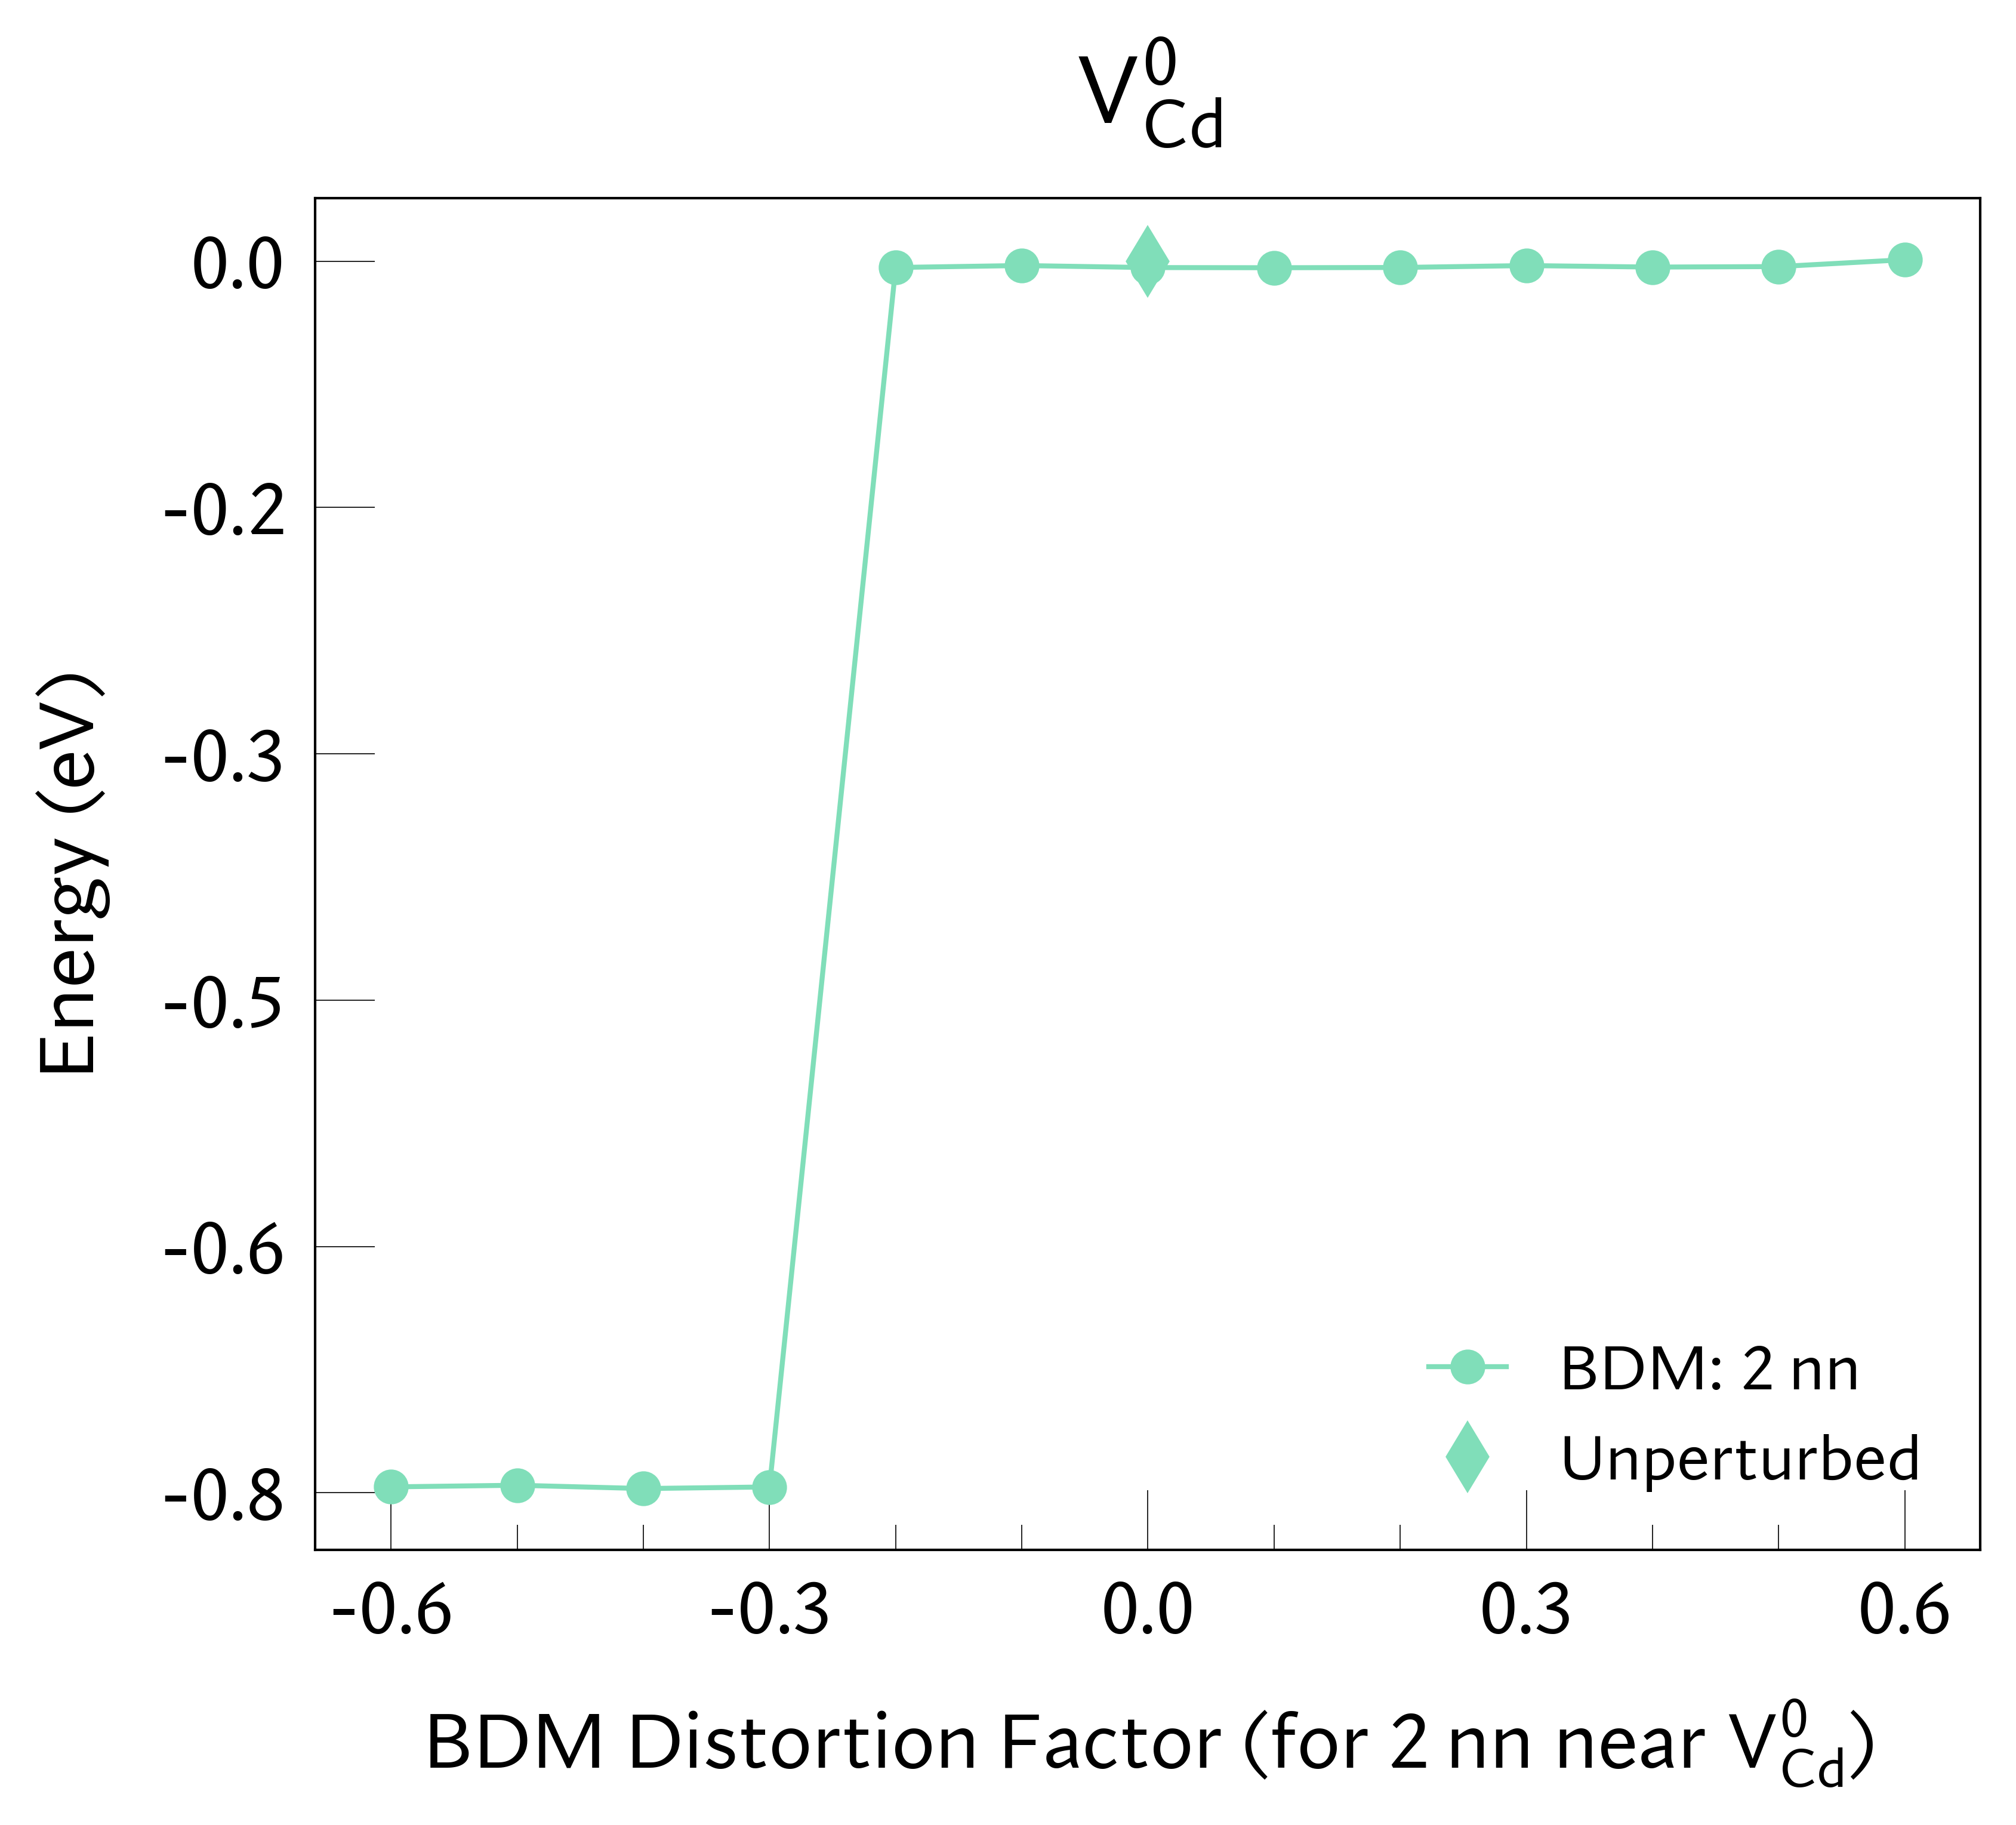

In [13]:
# Let's do the CdTe vacancies
output_path = os.getcwd()+"/output_V_Cd/" # where the output is
print("Directory where your ouput is? \n", output_path)

print("\nLet's see if BDM found any energy lowering distortion...")
print("Will show a plot for the defects where BDM did find it\n")

plot_all_defects({"vac_1_Cd":[0,-1,-2]
                  },
                 output_path,                
                 add_colorbar=False)

##### Can also add a colorbar 
More informative if you add a colorbar showing the structural similarity between the final structures.   
For this you need the CONTCAR's obtained with each BDM distortion.  
You can either use:
* root mean squared displacement (normalized by (Vol / nsites) ** (1/3)) (`rms` = 0) or 
* maximum distance between paired sites (`rms` = 1).   

A more detailed description of these functions can be found: [Pymatgen Structure Matcher](https://pymatgen.org/pymatgen.analysis.structure_matcher.html) and look for `get_rms_dist`

vac_1_Cd_0 : E diff. between minimum found with -0.4 RBDM and unperturbed: -0.75 eV 

Plot saved to C:\Users\Irea\Documents\Python_Modules\BDM\BDM_example_notebook/plots/


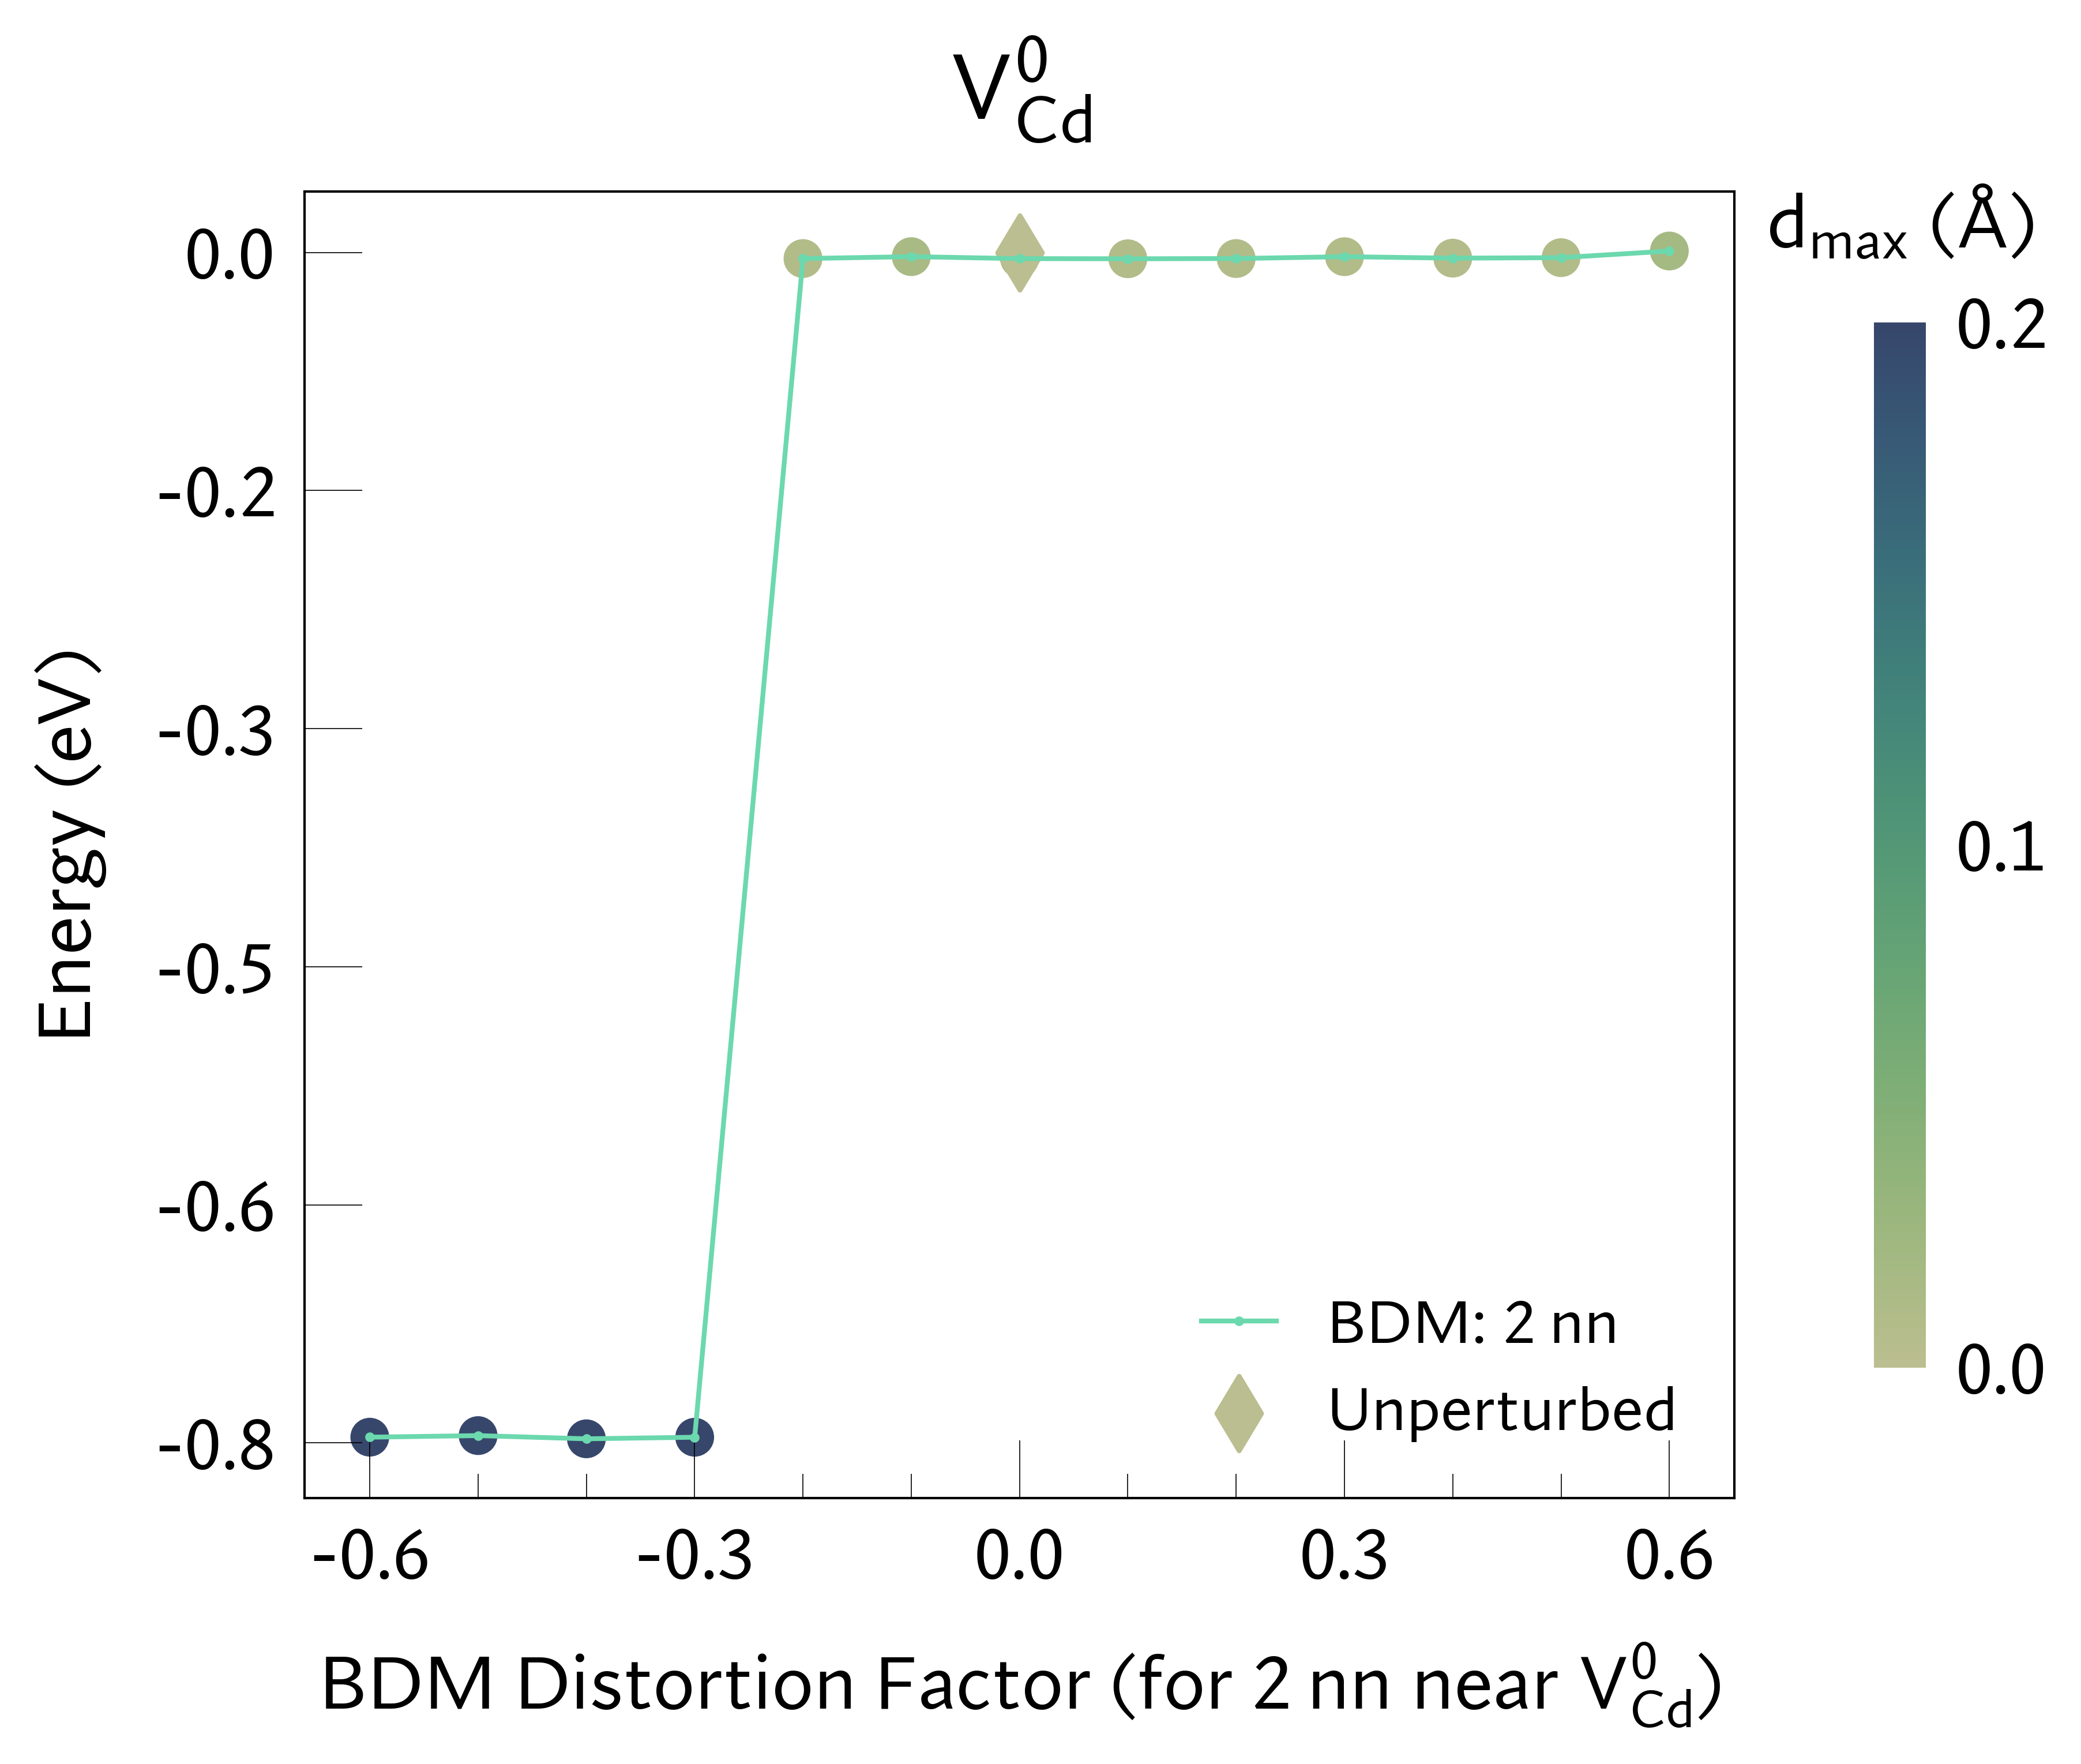

BDM only found a significant energy lowering distortion for V_{Cd}^0


In [14]:
plot_all_defects({"vac_1_Cd": [0,-1,-2] },
                 output_path,            
                 add_colorbar = True, # Set add_colorbar to True 
                 rms = 1, # maximum distance between paired sites
                ) 

print("BDM only found a significant energy lowering distortion for V_{Cd}^0")

<a id='analyse_defect_distortions'></a>

#### 5. Analyse the defect distortions found with BDM

Can quickly analyse the defect distortion with some of the functions from `BDM.analyse_defects`:

In [15]:
output_path = os.getcwd()+"/output_V_Cd/" # where the output is
print("Directory where your ouput is? \n", output_path)

Directory where your ouput is? 
 C:\Users\Irea\Documents\Python_Modules\BDM\BDM_example_notebook/output_V_Cd/


In [16]:
from BDM.analyse_defects import get_structures, analyse_structure, compare_structures
# Grab all structures obtained with BDM and Unperturbed relaxation.   
# This gives a dictionary matching BDM distortion to final structure
vac_1_Cd_0 = get_structures("vac_1_Cd_0", output_path)

# Can then analyse a certain BDM final structure with:
analyse_structure("vac_1_Cd_0", vac_1_Cd_0["Unperturbed"], output_path)
analyse_structure("vac_1_Cd_0", vac_1_Cd_0[-0.4], output_path)

==>  vac_1_Cd_0 structural analysis   <==
Analysing site U [0. 0. 0.]
Local order parameters (i.e. resemblence to given structural motif): 


,Coordination,Factor
0,square co-planar,0.083521
1,tetrahedral,0.999834
2,rectangular see-saw-like,0.007800
3,see-saw-like,0.238765
4,trigonal pyramidal,0.249775



Bond-lengths (in A) to nearest neighbours: 


,Element,Distance
0,Te,2.611
1,Te,2.611
2,Te,2.637
3,Te,2.636



==>  vac_1_Cd_0 structural analysis   <==
Analysing site U [0. 0. 0.]
Local order parameters (i.e. resemblence to given structural motif): 


,Coordination,Factor
0,square co-planar,0.159079
1,tetrahedral,0.733275
2,rectangular see-saw-like,0.056519
3,see-saw-like,0.223326
4,trigonal pyramidal,0.230578



Bond-lengths (in A) to nearest neighbours: 


,Element,Distance
0,Te,2.189
1,Te,2.199
2,Te,2.661
3,Te,2.681


Can also compare the structural similary between all the BDM structures with `compare_structures`. It prints the root mean squared displacement,
maximum distance between paired sites, and energy (relative to unperturbed structure) of all BDM final structures relative to the Unperturbed 

In [17]:
from BDM.analyse_defects import get_energies, get_structures, analyse_structure, compare_structures

output_path = os.getcwd()+"/output_V_Cd/"
vac_1_Cd_0 = get_structures("vac_1_Cd_0", output_path)
defect_energies = get_energies("vac_1_Cd_0", output_path)
structure_comparison = compare_structures(vac_1_Cd_0, 
                                          defect_energies , 
                                          compare_to="Unperturbed",
                                         )

vac_1_Cd_0 : E diff. between minimum found with -0.4 RBDM and unperturbed: -0.75 eV 

Comparing structures to Unperturbed...


,BDM Dist.,rms,max. dist (A),Rel. E (eV)
0,-0.6,0.067,0.250,-0.75
1,-0.5,0.067,0.249,-0.75
2,-0.4,0.067,0.250,-0.75
3,-0.3,0.067,0.250,-0.75
4,-0.2,0.004,0.008,-0.00
5,-0.1,0.007,0.016,-0.00
6,0.0,0.006,0.015,-0.00
7,0.1,0.005,0.009,-0.00
8,0.2,0.004,0.010,-0.00
9,0.3,0.004,0.008,-0.00
